--- Loading Datasets ---
Validation and Test data loaded successfully!

Validation Set Counts:
gcs_class
3    371
5    264
2    115
Name: count, dtype: int64

Test Set Counts:
gcs_class
3    151
5    109
2     28
Name: count, dtype: int64

--- Training FINAL Decision Tree on FULL Validation Set ---
Final model training complete.

==================== FINAL PERFORMANCE ON UNSEEN TEST SET ====================

Classification Report (Test Set):
              precision    recall  f1-score   support

       GCS 2       0.32      0.79      0.46        28
       GCS 3       0.73      0.58      0.64       151
     GCS 4/5       0.64      0.60      0.62       109

    accuracy                           0.60       288
   macro avg       0.57      0.65      0.57       288
weighted avg       0.66      0.60      0.62       288


Overall Accuracy (Test Set): 60.42%

Confusion Matrix (Test Set):


/tmp/ipykernel_68507/3545217481.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['perplexity'].fillna(100000, inplace=True)
/tmp/ipykernel_68507/3545217481.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

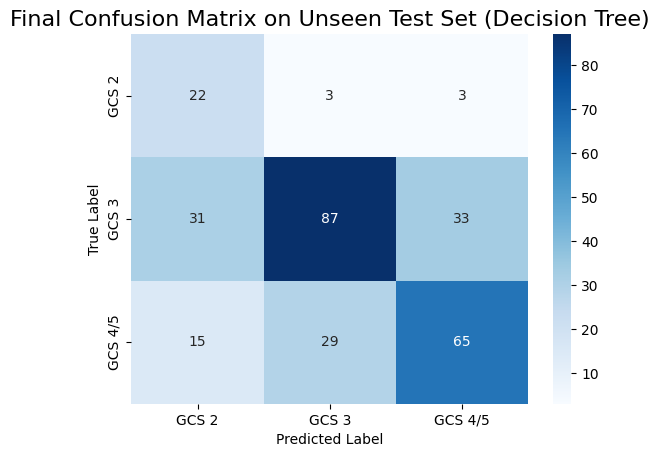

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

# --- Step 1: Load BOTH Validation and Test Datasets ---
project_root = ".." 
results_dir = os.path.join(project_root, "results")
validation_csv_path = os.path.join(results_dir, "features_validation_set.csv")
test_csv_path = os.path.join(results_dir, "features_test_set.csv")

print("--- Loading Datasets ---")
df_val = pd.read_csv(validation_csv_path)
df_test = pd.read_csv(test_csv_path)
print("Validation and Test data loaded successfully!")

# --- Step 2: Prepare BOTH Datasets ---
def prepare_data(df):
    """A helper function to prepare the dataframes."""
    def get_gcs_class(category):
        if category == 'gcs_2': return 2
        if category == 'gcs_3': return 3
        if category == 'gcs_45_clean': return 5
        return 0
    
    df['gcs_class'] = df['category'].apply(get_gcs_class)
    df_clean = df[df['gcs_class'] != 0].copy()
    
    # Handle NaN values
    df_clean['perplexity'].fillna(100000, inplace=True)
    df_clean.fillna(df_clean.median(numeric_only=True), inplace=True)
    return df_clean

df_val_clean = prepare_data(df_val)
df_test_clean = prepare_data(df_test)

print("\nValidation Set Counts:")
print(df_val_clean['gcs_class'].value_counts())
print("\nTest Set Counts:")
print(df_test_clean['gcs_class'].value_counts())

# --- Step 3: Train the FINAL Decision Tree on the FULL Validation Set ---
print("\n--- Training FINAL Decision Tree on FULL Validation Set ---")

# Define features (X) and labels (y) for the validation set
feature_columns = ['avg_logprob', 'lexical_validity', 'perplexity']
X_val = df_val_clean[feature_columns]
y_val = df_val_clean['gcs_class']

# Initialize the classifier with the same parameters as before
dt_classifier_final = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)

# Train the model on the entire validation set
dt_classifier_final.fit(X_val, y_val)
print("Final model training complete.")

# --- Step 4: Evaluate the Final Model on the UNSEEN Test Set ---
print("\n" + "="*20 + " FINAL PERFORMANCE ON UNSEEN TEST SET " + "="*20)

# Define features (X) and labels (y) for the test set
X_test = df_test_clean[feature_columns]
y_test_true = df_test_clean['gcs_class']

# Make predictions on the test set
y_test_predicted = dt_classifier_final.predict(X_test)

# --- Step 5: Report the Final, Unbiased Performance ---
report_labels = [2, 3, 5]
report_target_names = ['GCS 2', 'GCS 3', 'GCS 4/5']

print("\nClassification Report (Test Set):")
print(classification_report(y_test_true, y_test_predicted, 
                            labels=report_labels, 
                            target_names=report_target_names,
                            zero_division=0))

print(f"\nOverall Accuracy (Test Set): {accuracy_score(y_test_true, y_test_predicted):.2%}")

print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test_true, y_test_predicted, labels=[2, 3, 5])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=report_target_names,
            yticklabels=report_target_names)
plt.title('Final Confusion Matrix on Unseen Test Set (Decision Tree)', fontsize=16)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()